<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/clinicalbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: 
[https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=0unZ2xh4QDap](https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=0unZ2xh4QDap)

In [75]:
import numpy as np, pandas as pd 
import os
import zipfile

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import torch

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# ! pip install transformers datasets
from transformers import AutoTokenizer, AutoModel


In [76]:
# Setup
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()



Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [77]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
ind_dct = {k: v for v, k in enumerate(df[0].tolist())}

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [78]:
def get_embedding(text):
  """
  Input: a sentence (that contains word of interest)
  Output: embedding as a list
  """
  marked_text = "[CLS] " + text + " [SEP]"

  # Tokenize our sentence with the BERT tokenizer.
  tokenized_text = tokenizer.tokenize(marked_text)

  # Print out the tokens.
  print (tokenized_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  # Mark each of the 22 tokens as belonging to sentence "1".
  segments_ids = [1] * len(tokenized_text)

  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  # Run the text through BERT, and collect all of the hidden states produced
  # from all 12 layers. 
  with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

  token_vecs = hidden_states[-2][0]
  sentence_embedding = torch.mean(token_vecs, dim=0)
  return sentence_embedding.tolist()

In [79]:
def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(get_embedding(item))
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

['[CLS]', 'z', '##ol', '##pid', '##em', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'di', '##ar', '##r', '##hea', '[SEP]']
['[CLS]', 'z', '##ol', '##pid', '##em', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'di', '##ar', '##r', '##hea', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


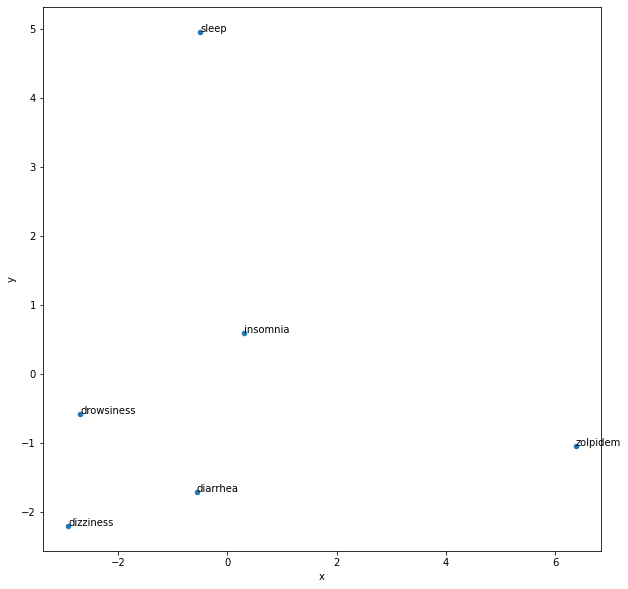

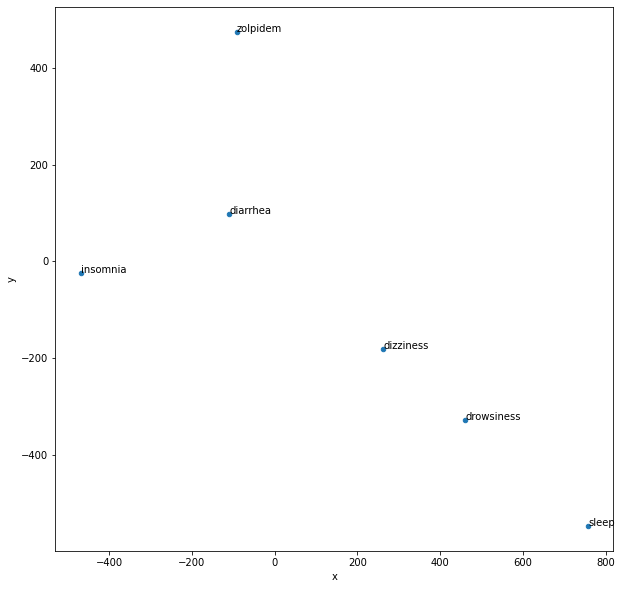

In [80]:
plot_with_labels('zolpidem')
plot_with_labels('zolpidem', False)

['[CLS]', 'z', '##ale', '##p', '##lon', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'fever', '[SEP]']
['[CLS]', 'con', '##st', '##ip', '##ation', '[SEP]']
['[CLS]', 'd', '##ys', '##pe', '##ps', '##ia', '[SEP]']
['[CLS]', 'art', '##hr', '##itis', '[SEP]']
['[CLS]', 'my', '##al', '##gia', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'br', '##on', '##chi', '##tis', '[SEP]']
['[CLS]', 'z', '##ale', '##p', '##lon', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'fever', '[SEP]']
['[CLS]', 'con', '##st', '##ip', '##ation', '[SEP]']
['[CLS]', 'd', '##ys', '##pe', '##ps', '##ia', '[SEP]']
['[CLS]', 'art', '##hr', '##itis', '[SEP]']
['[CLS]', 'my', '##al', '##gia', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'br', '##on', '##chi', '##tis', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


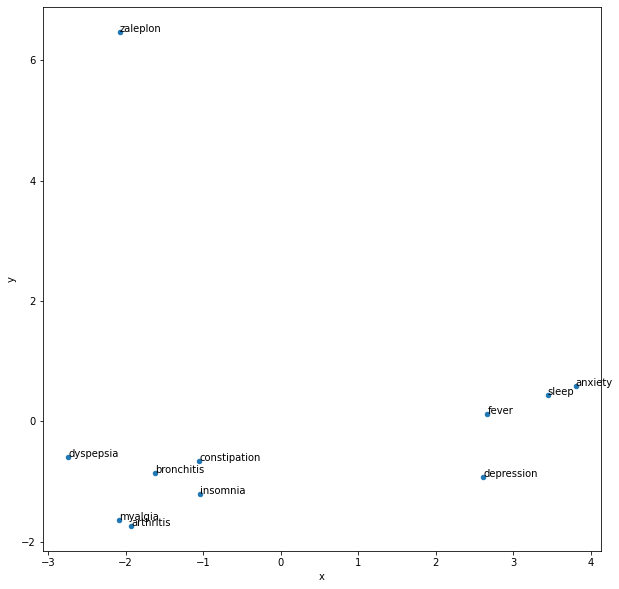

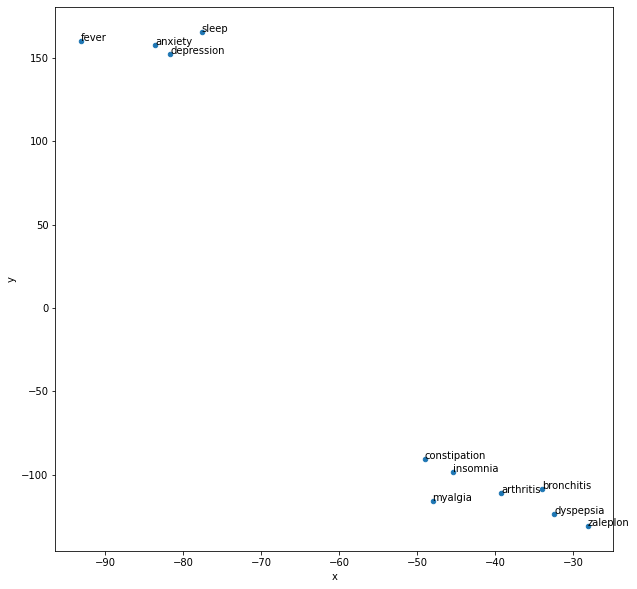

In [81]:
plot_with_labels('zaleplon')
plot_with_labels('zaleplon', False)

['[CLS]', 't', '##raz', '##od', '##one', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'ed', '##ema', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'di', '##ar', '##r', '##hea', '[SEP]']
['[CLS]', 'nasal', '[SEP]']
['[CLS]', 'congestion', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'p', '##ria', '##pis', '##m', '[SEP]']
['[CLS]', 't', '##raz', '##od', '##one', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'ed', '##ema', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'di', '##ar', '##r', '##hea', '[SEP]']
['[CLS]', 'nasal', '[SEP]']
['[CLS]', 'congestion', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'p', '##ria', '##pis', '##m', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


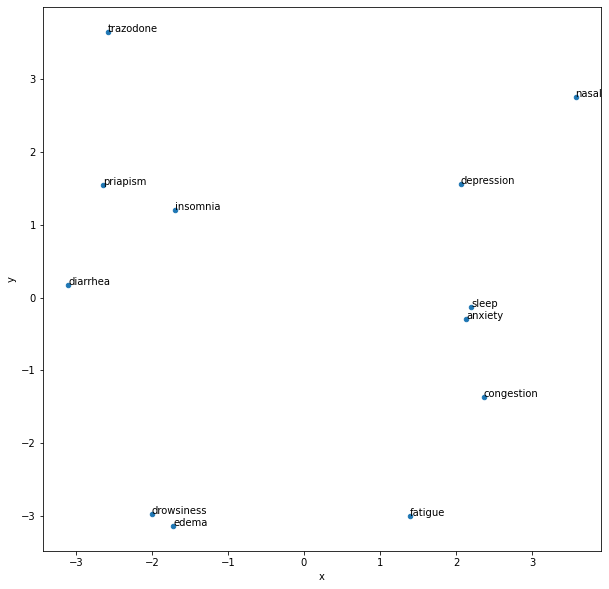

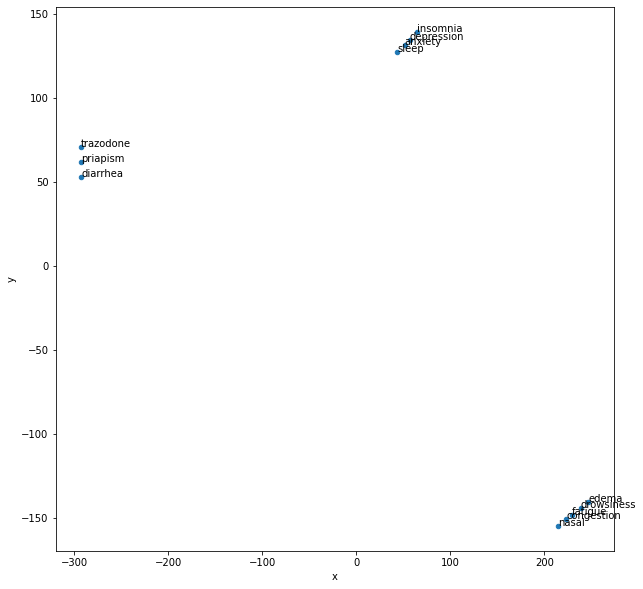

In [82]:
plot_with_labels('trazodone')
plot_with_labels('trazodone', False)

['[CLS]', 'am', '##it', '##rip', '##ty', '##line', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'weight', '[SEP]']
['[CLS]', 'gain', '[SEP]']
['[CLS]', 'con', '##st', '##ip', '##ation', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'mi', '##gra', '##ine', '[SEP]']
['[CLS]', 'am', '##it', '##rip', '##ty', '##line', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'weight', '[SEP]']
['[CLS]', 'gain', '[SEP]']
['[CLS]', 'con', '##st', '##ip', '##ation', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'mi', '##gra', '##ine', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


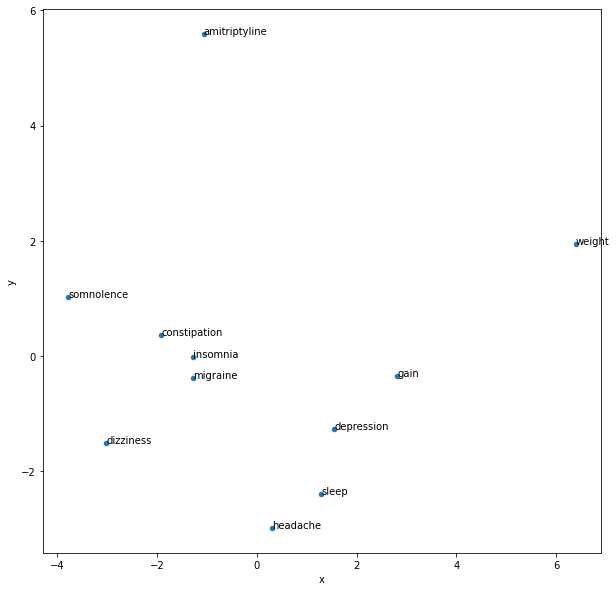

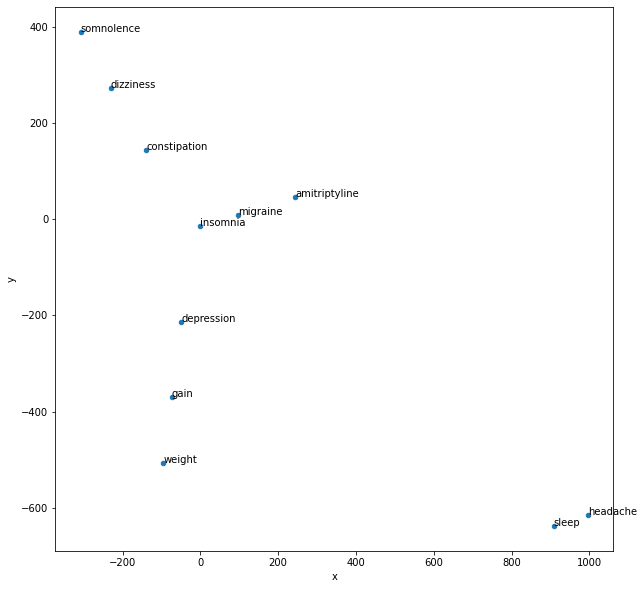

In [83]:
plot_with_labels('amitriptyline')
plot_with_labels('amitriptyline', False)

['[CLS]', 'mi', '##rta', '##za', '##pine', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'confusion', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'agitation', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'vomit', '##ing', '[SEP]']
['[CLS]', 'sweating', '[SEP]']
['[CLS]', 'mi', '##rta', '##za', '##pine', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'confusion', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'agitation', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'vomit', '##ing', '[SEP]']
['[CLS]', 'sweating', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


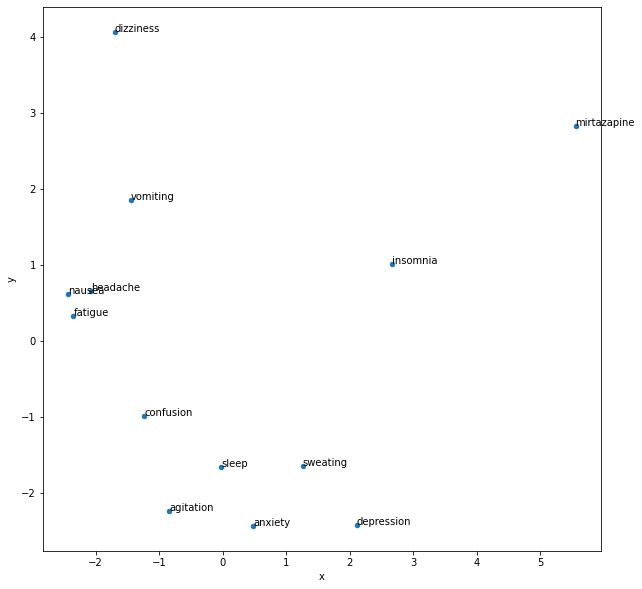

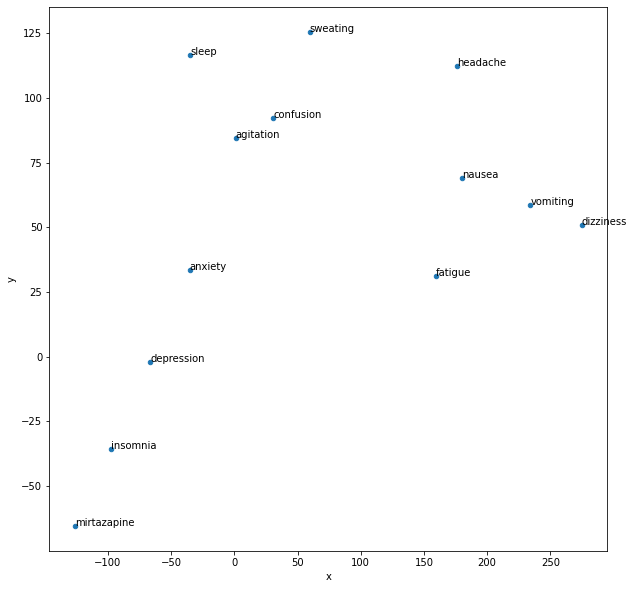

In [84]:
plot_with_labels('mirtazapine')
plot_with_labels('mirtazapine', False)

['[CLS]', 'do', '##xe', '##pin', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'do', '##xe', '##pin', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


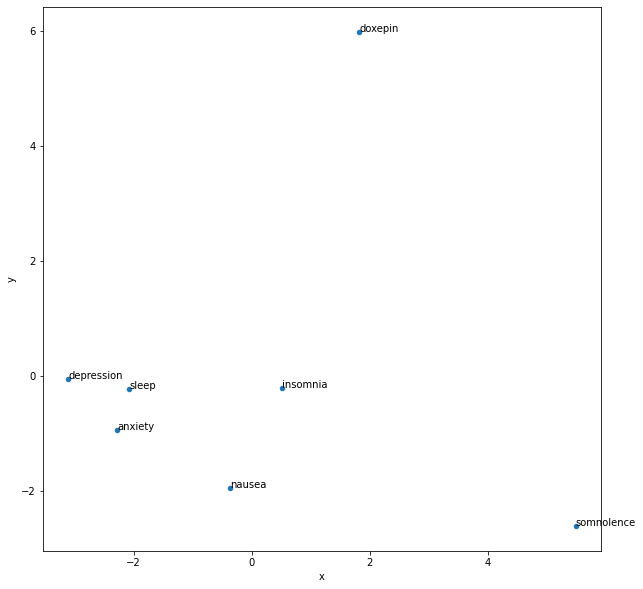

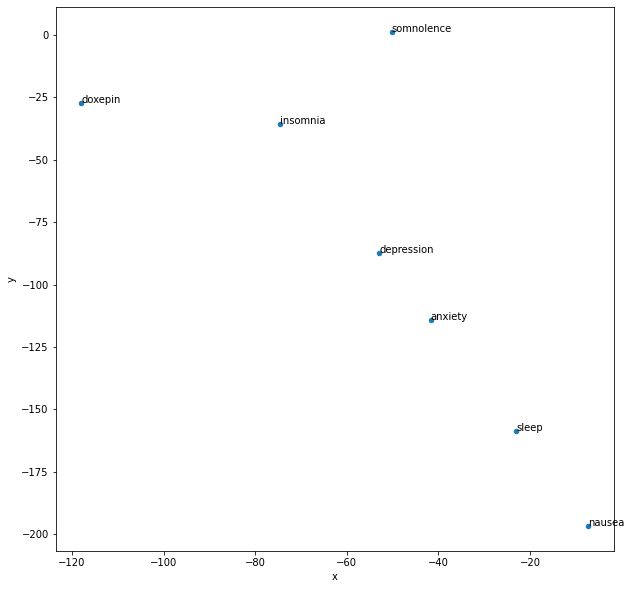

In [85]:
plot_with_labels('doxepin')
plot_with_labels('doxepin', False)

['[CLS]', 'lo', '##raze', '##pa', '##m', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'seizure', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'se', '##dation', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'weakness', '[SEP]']
['[CLS]', 'un', '##stead', '##iness', '[SEP]']
['[CLS]', 'alcohol', '[SEP]']
['[CLS]', 'panic', '[SEP]']
['[CLS]', 'lo', '##raze', '##pa', '##m', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'seizure', '[SEP]']
['[CLS]', 'anxiety', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'se', '##dation', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'weakness', '[SEP]']
['[CLS]', 'un', '##stead', '##iness', '[SEP]']
['[CLS]', 'alcohol', '[SEP]']
['[CLS]', 'panic', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


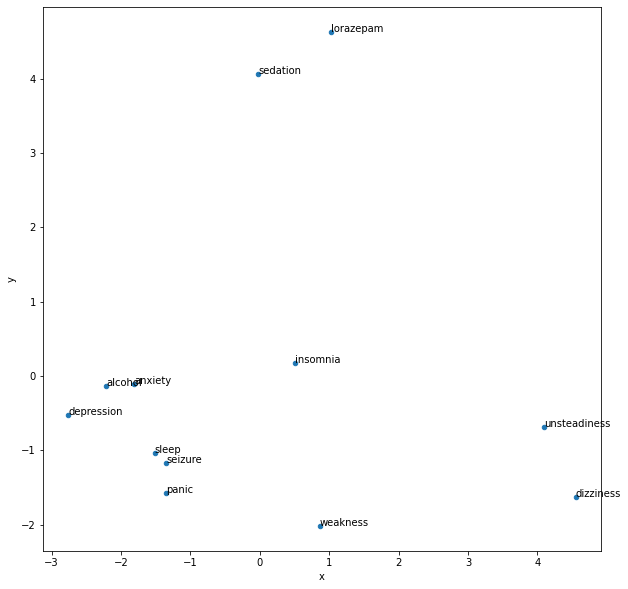

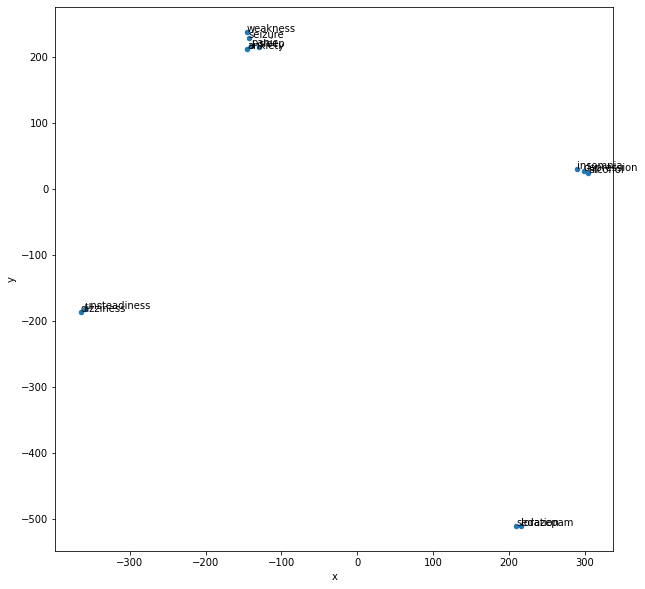

In [86]:
plot_with_labels('lorazepam')
plot_with_labels('lorazepam', False)

['[CLS]', 'c', '##lon', '##az', '##ep', '##am', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'seizure', '[SEP]']
['[CLS]', 'panic', '[SEP]']
['[CLS]', 'disorder', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'restless', '[SEP]']
['[CLS]', 'leg', '[SEP]']
['[CLS]', 'man', '##ia', '[SEP]']
['[CLS]', 'c', '##lon', '##az', '##ep', '##am', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'seizure', '[SEP]']
['[CLS]', 'panic', '[SEP]']
['[CLS]', 'disorder', '[SEP]']
['[CLS]', 'depression', '[SEP]']
['[CLS]', 'restless', '[SEP]']
['[CLS]', 'leg', '[SEP]']
['[CLS]', 'man', '##ia', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


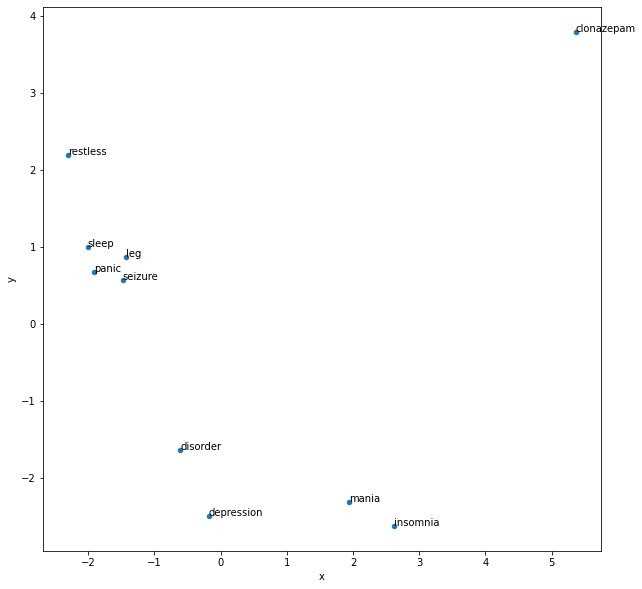

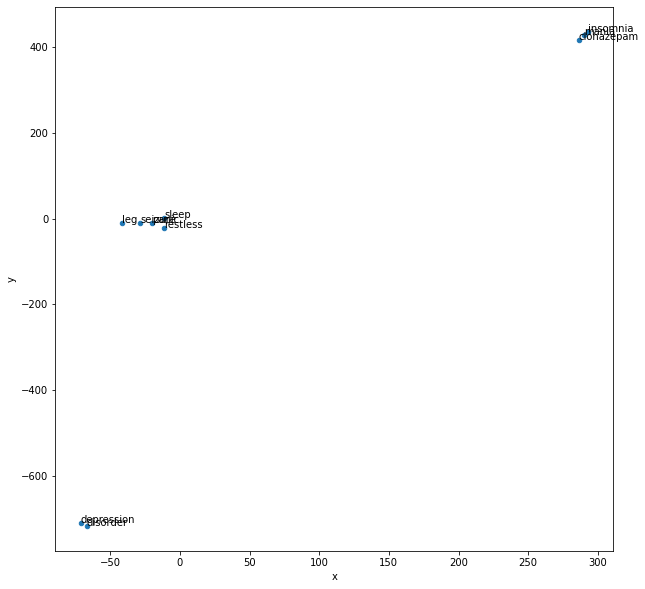

In [87]:
plot_with_labels('clonazepam')
plot_with_labels('clonazepam', False)

['[CLS]', 'te', '##ma', '##ze', '##pa', '##m', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'nervous', '##ness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'let', '##har', '##gy', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'te', '##ma', '##ze', '##pa', '##m', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'nervous', '##ness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'let', '##har', '##gy', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'nausea', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


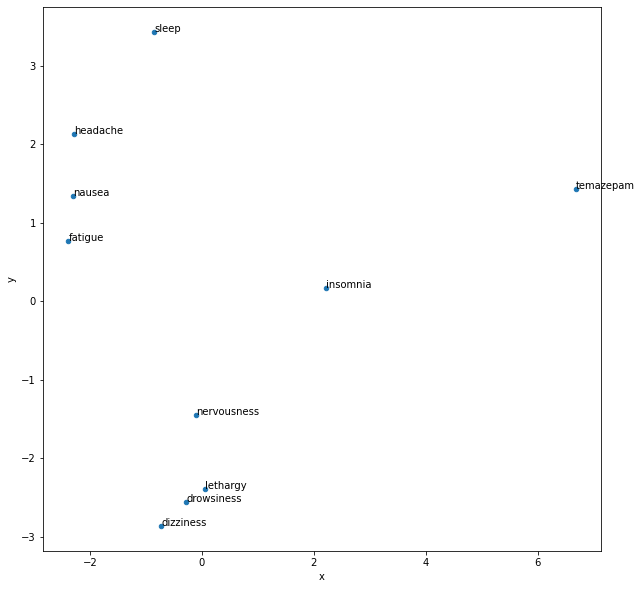

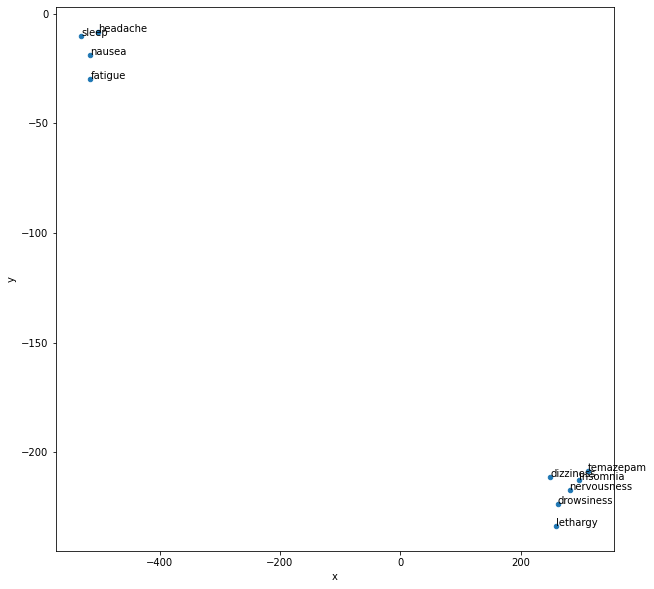

In [88]:
plot_with_labels('temazepam')
plot_with_labels('temazepam', False)

['[CLS]', 't', '##ria', '##zo', '##lam', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 't', '##ria', '##zo', '##lam', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'so', '##m', '##no', '##len', '##ce', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'fatigue', '[SEP]']
['[CLS]', 'nausea', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


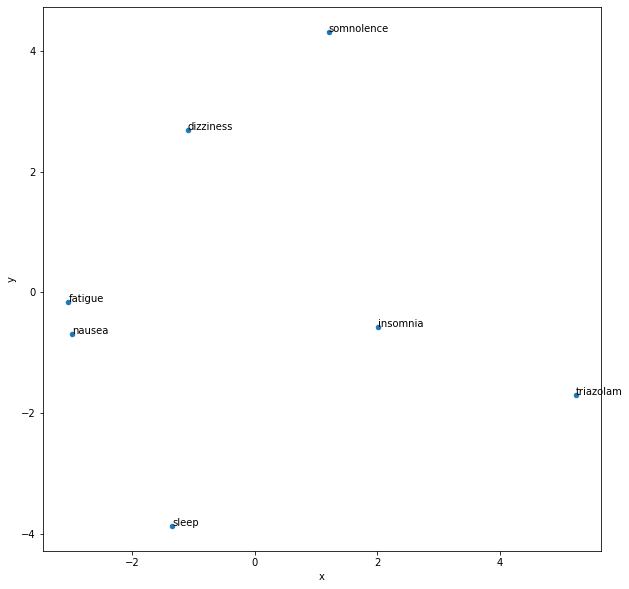

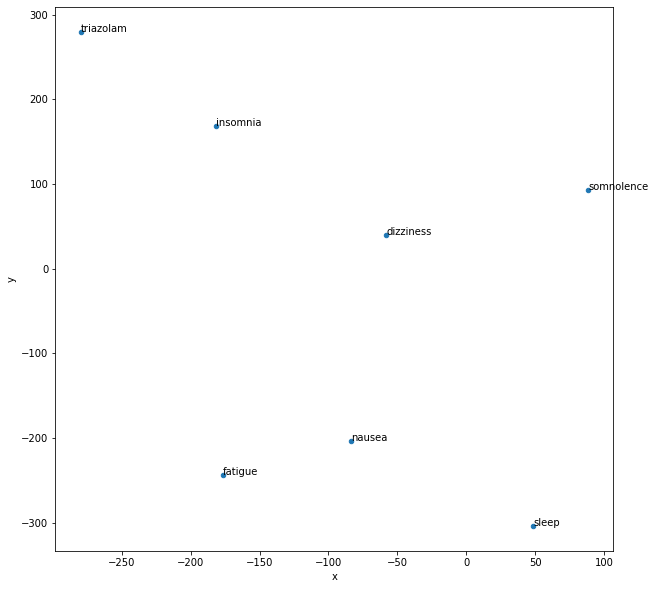

In [89]:
plot_with_labels('triazolam')
plot_with_labels('triazolam', False)

['[CLS]', 'me', '##lat', '##oni', '##n', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'jet', '##lag', '[SEP]']
['[CLS]', 'p', '##al', '##pit', '##ations', '[SEP]']
['[CLS]', 'me', '##lat', '##oni', '##n', '[SEP]']
['[CLS]', 'ins', '##om', '##nia', '[SEP]']
['[CLS]', 'sleep', '[SEP]']
['[CLS]', 'di', '##zzi', '##ness', '[SEP]']
['[CLS]', 'headache', '[SEP]']
['[CLS]', 'nausea', '[SEP]']
['[CLS]', 'd', '##rows', '##iness', '[SEP]']
['[CLS]', 'jet', '##lag', '[SEP]']
['[CLS]', 'p', '##al', '##pit', '##ations', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


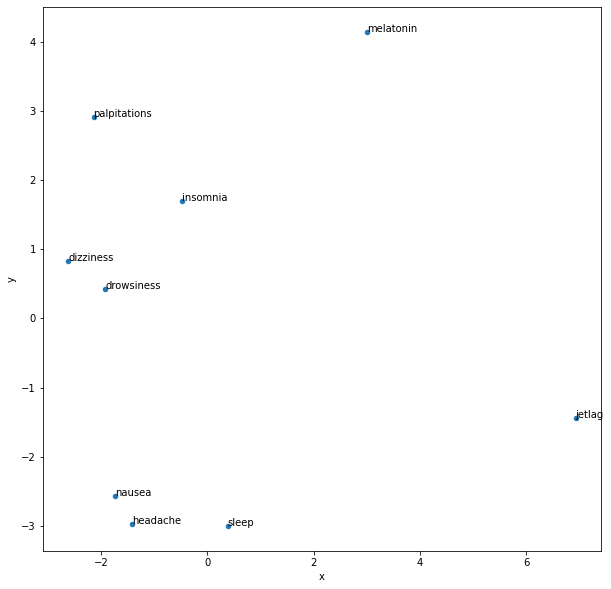

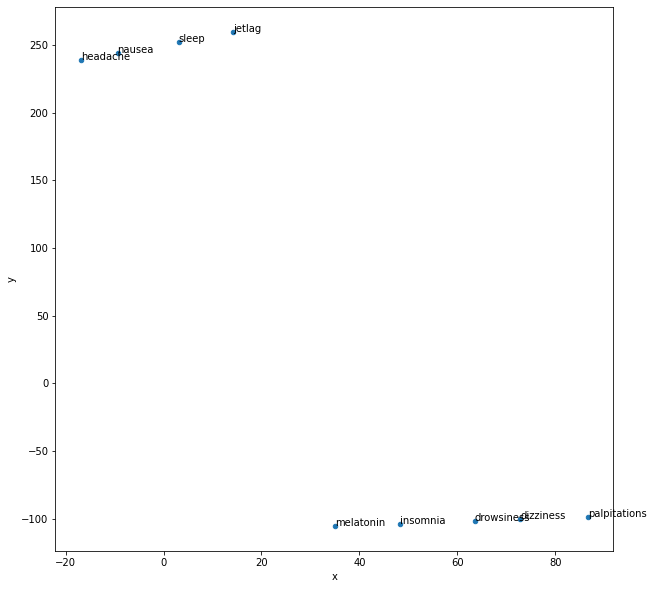

In [90]:
plot_with_labels('melatonin')
plot_with_labels('melatonin', False)

['[CLS]', 'z', '##ol', '##pid', '##em', '[SEP]']
['[CLS]', 'es', '##zo', '##pic', '##lone', '[SEP]']
['[CLS]', 'z', '##ale', '##p', '##lon', '[SEP]']
['[CLS]', 't', '##raz', '##od', '##one', '[SEP]']
['[CLS]', 'am', '##it', '##rip', '##ty', '##line', '[SEP]']
['[CLS]', 'mi', '##rta', '##za', '##pine', '[SEP]']
['[CLS]', 'do', '##xe', '##pin', '[SEP]']
['[CLS]', 'lo', '##raze', '##pa', '##m', '[SEP]']
['[CLS]', 'c', '##lon', '##az', '##ep', '##am', '[SEP]']
['[CLS]', 'te', '##ma', '##ze', '##pa', '##m', '[SEP]']
['[CLS]', 't', '##ria', '##zo', '##lam', '[SEP]']
['[CLS]', 'me', '##lat', '##oni', '##n', '[SEP]']
['[CLS]', 'at', '##or', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'at', '##or', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'flu', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'lo', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'p', '##ra', '##vas', '##tat', '##in', '[SEP]']


0     Text(-0.9839749640508129, -1.6866569240576994,...
1     Text(-2.3698289046901966, -1.5809233860138079,...
2     Text(-2.3114546763953823, -1.9269288223983934,...
3     Text(-1.1892631392241642, 0.8250316366816751, ...
4     Text(-1.025529331594093, 0.898651870544442, 'a...
5     Text(-0.6461914801955981, -1.1288697817196345,...
6     Text(-2.2126810465938993, -1.7090521751993077,...
7     Text(-0.45930614993468233, 2.6825382537088305,...
8     Text(-1.294844269462576, 1.428473924839406, 'c...
9     Text(-0.6994932894559891, 1.0164498583884207, ...
10    Text(-1.8134121548357511, 0.3730936970664112, ...
11    Text(-0.7271776199985205, 2.6893966577384854, ...
12    Text(3.5133284137762026, -0.4194334760687618, ...
13    Text(3.5133284137762026, -0.4194334760687618, ...
14    Text(2.905631284256189, -0.5950781144682181, '...
15    Text(2.7405618488778387, -0.00503339901012668,...
16    Text(3.0603070657452274, -0.4422263439629628, ...
dtype: object

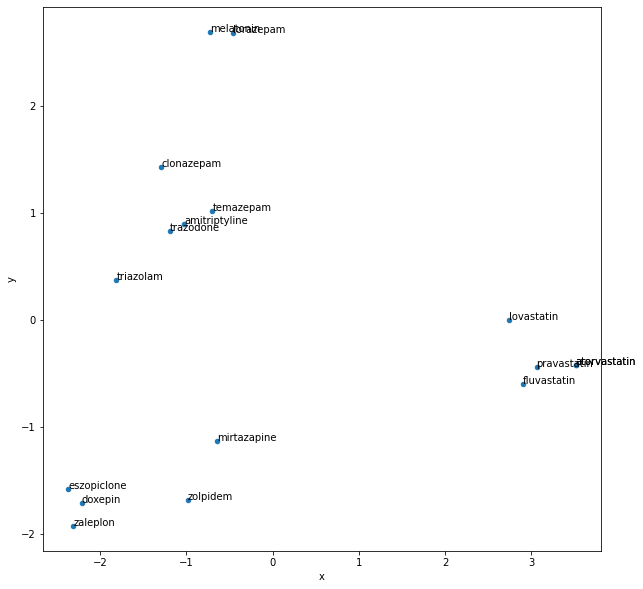

In [91]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

['[CLS]', 'z', '##ol', '##pid', '##em', '[SEP]']
['[CLS]', 'es', '##zo', '##pic', '##lone', '[SEP]']
['[CLS]', 'z', '##ale', '##p', '##lon', '[SEP]']
['[CLS]', 't', '##raz', '##od', '##one', '[SEP]']
['[CLS]', 'am', '##it', '##rip', '##ty', '##line', '[SEP]']
['[CLS]', 'mi', '##rta', '##za', '##pine', '[SEP]']
['[CLS]', 'do', '##xe', '##pin', '[SEP]']
['[CLS]', 'lo', '##raze', '##pa', '##m', '[SEP]']
['[CLS]', 'c', '##lon', '##az', '##ep', '##am', '[SEP]']
['[CLS]', 'te', '##ma', '##ze', '##pa', '##m', '[SEP]']
['[CLS]', 't', '##ria', '##zo', '##lam', '[SEP]']
['[CLS]', 'me', '##lat', '##oni', '##n', '[SEP]']
['[CLS]', 'at', '##or', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'at', '##or', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'flu', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'lo', '##vas', '##tat', '##in', '[SEP]']
['[CLS]', 'p', '##ra', '##vas', '##tat', '##in', '[SEP]']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0     Text(-154.36729431152344, -403.0128173828125, ...
1     Text(-105.38053894042969, 92.56040954589844, '...
2     Text(-149.00680541992188, -405.146484375, 'zal...
3     Text(-100.96988677978516, 103.680908203125, 't...
4     Text(-91.5635986328125, 94.00785827636719, 'am...
5     Text(-70.41751098632812, 124.88446807861328, '...
6     Text(-140.80894470214844, -408.4126892089844, ...
7     Text(-85.46517944335938, 114.44046020507812, '...
8     Text(-95.67102813720703, 107.36023712158203, '...
9     Text(-77.52640533447266, 119.95092010498047, '...
10    Text(-106.74292755126953, 115.87495422363281, ...
11    Text(-112.92556762695312, 103.4386215209961, '...
12    Text(348.7962341308594, -60.862396240234375, '...
13    Text(353.4696044921875, -63.91921615600586, 'a...
14    Text(-162.98558044433594, 566.1884765625, 'flu...
15    Text(-168.53076171875, 565.5302124023438, 'lov...
16    Text(357.13043212890625, -53.223968505859375, ...
dtype: object

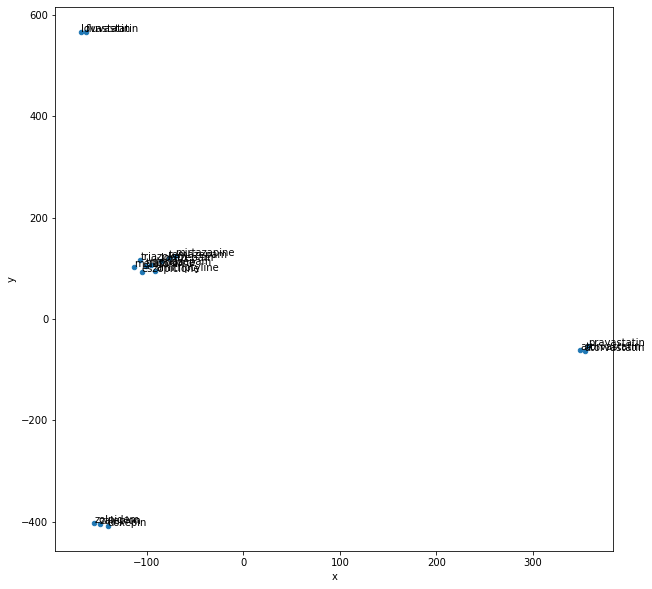

In [92]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

In [93]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 patient
2 had
3 50
4 mg
5 of
6 t
7 ##raz
8 ##od
9 ##one
10 .
11 [SEP]


In [94]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

len(token_vecs_sum[7:-1][:5])

4

Trazadone is split into 4 different tokens. Thus, we see that it is a list of 4 tensors.

Should we concat the tensors to one tensor? or are there 